In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.externals import joblib

from helpfunction import sciNot

%matplotlib inline
gr      = 1.618

In [2]:
min_dedx_hits=5
min_reco_e=0.03
z_dead_start = 675
z_dead_end=z_dead_start+100

pd.options.display.max_columns = 999

# Tracks

In [3]:
input_tr = ['../Input/lee_75k/lee_75k_track_9.pckl',
            '../Input/intime/intime_track_9.pckl',
            
            '../Input/nue/nue_track_0.pckl',
            '../Input/nue/nue_track_1.pckl',
            '../Input/nue/nue_track_2.pckl',
            '../Input/nue/nue_track_3.pckl',
            '../Input/nue/nue_track_4.pckl',
            
            '../Input/nu/nu_track_4.pckl',
            '../Input/nu/nu_track_5.pckl',
            '../Input/nu/nu_track_6.pckl',
            '../Input/nu/nu_track_7.pckl',
           ]

input_test = ['../Input/nu/nu_track_0.pckl',
              '../Input/nu/nu_track_1.pckl',
              '../Input/nu/nu_track_2.pckl',
              '../Input/nu/nu_track_3.pckl',
           ]


#input_tr_data = ['../Input/XGBoost/bnb/trackFrame_data_bnb.pckl',
#                 '../Input/XGBoost/bnbext/trackFrame_data_bnbext.pckl'
#                ]

intput_tr_df = [ pd.read_pickle(x) for x in input_tr]
df_tr_train = pd.concat(intput_tr_df,ignore_index=True,copy=False) 

intput_tr_df = [ pd.read_pickle(x) for x in input_test]
df_tr_test = pd.concat(intput_tr_df,ignore_index=True,copy=False) 


# Do some things before training on the frame
df_tr_train = pd.get_dummies(df_tr_train,columns=['track_is_daughter','track_daughter'],drop_first=True)
#df_tr_train["vtx_activity"] = df_tr_train["vtx_activity"].astype("bool")
df_tr_train["true_mu"] = df_tr_train["matched_tracks"].abs() == 13
df_tr_train["true_e"] = df_tr_train["matched_tracks"] == 11


# Do some things before testing on the frame
df_tr_test = pd.get_dummies(df_tr_test,columns=['track_is_daughter','track_daughter'],drop_first=True)
df_tr_test["vtx_activity"] = df_tr_test["vtx_activity"].astype("bool")
df_tr_test["true_mu"] = df_tr_test["matched_tracks"].abs() == 13
df_tr_test["true_e"] = df_tr_test["matched_tracks"] == 11


columns_track_XGB =       ['track_vtxdistance', 'track_maxangle',
                           'track_spacepoint_dqdx_ratio', 'predict_cos', 'track_pca',
                           'track_dedx_best_w',
                           'predict_mu', 'predict_pi',
                           'track_dedx_hits_w', 'predict_p',
                           'track_dedx_w', 'track_containment',
                           'track_hitsratio_w', 'predict_em', 
                           "track_len",
                           'track_is_daughter_1',"track_is_daughter_2", "track_daughter_1", "track_daughter_2", "track_daughter_3",
                           #'track_res_std','track_energy_w', 'track_res_mean', 'track_theta', 'track_hits_w' # <- These are the dangerous fields we prefer to avoid
                          ]


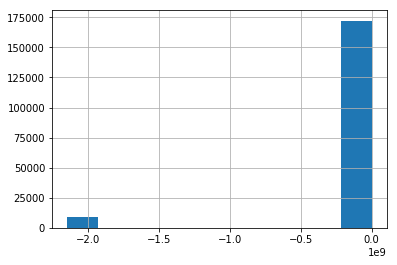

In [4]:
df_tr_train.head(10)
df_tr_train["bnbweight"].hist()

In [5]:
# For now, quick fix: require at least x hits in track_dedx_hits, otherwise track_dedx is nonsence.
# Also require a reconstructed energy of at leact x Mev
df_tr_train = df_tr_train[df_tr_train['track_dedx_hits_w']>=min_dedx_hits]
df_tr_test = df_tr_test[df_tr_test['track_dedx_hits_w']>=min_dedx_hits]
df_tr_train = df_tr_train[df_tr_train['track_energy_w']>=min_reco_e]
df_tr_test = df_tr_test[df_tr_test['track_energy_w']>=min_reco_e]
df_tr_train = df_tr_train[~df_tr_train['track_start_z'].between(z_dead_start,z_dead_end)]
df_tr_test = df_tr_test[~df_tr_test['track_start_z'].between(z_dead_start,z_dead_end)]

df_tr_train.head()
print(df_tr_train.columns)

Index(['track_cle', 'track_res_std', 'track_vtxdistance',
       'matched_tracks_energy', 'track_maxangle', 'track_end_y', 'track_end_x',
       'track_end_z', 'predict_p', 'track_len', 'track_spacepoint_dqdx_ratio',
       'predict_cos', 'track_pca', 'matched_tracks', 'track_hits_w',
       'track_start_y', 'track_start_z', 'track_start_x', 'bnbweight',
       'track_dedx_best_w', 'track_energy_w', 'track_bdt_precut', 'predict_mu',
       'predict_pi', 'track_dir_y', 'track_dir_x', 'track_dir_z',
       'track_dedx_hits_w', 'n_showers', 'track_dedx_w', 'fiducial',
       'true_1eX_signal', 'track_containment', 'track_hitsratio_w',
       'track_res_mean', 'predict_em', 'track_theta', 'vtx_activity',
       '__array_index', 'track_is_daughter_1', 'track_is_daughter_2',
       'track_daughter_1', 'track_daughter_2', 'track_daughter_3', 'true_mu',
       'true_e'],
      dtype='object')


In [6]:
X_train = df_tr_train[columns_track_XGB].as_matrix()
X_test  = df_tr_test[columns_track_XGB].as_matrix()

Y_train = df_tr_train[['true_mu','true_e','track_cle']]
Y_test = df_tr_test[['true_mu','true_e','track_cle']]

In [7]:
# fit model no training data
label = 'true_mu'
model = XGBClassifier()
model.fit(X_train, Y_train[label])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_tr_mu.pkl') 
y_pred_mu = model.predict_proba(X_test)
y_pred_mu_train = model.predict_proba(X_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.88      0.92      0.90     61108
       True       0.91      0.87      0.89     57228

avg / total       0.90      0.90      0.90    118336

Feature ranking:
1. feature predict_cos(0.161616)
2. feature predict_p(0.135642)
3. feature predict_pi(0.088023)
4. feature predict_mu(0.086580)
5. feature track_maxangle(0.085137)
6. feature track_vtxdistance(0.070707)
7. feature predict_em(0.049062)
8. feature track_len(0.046176)
9. feature track_is_daughter_2(0.044733)
10. feature track_pca(0.038961)
11. feature track_hitsratio_w(0.037518)
12. feature track_daughter_2(0.031746)
13. feature track_daughter_1(0.031746)
14. feature track_dedx_w(0.030303)
15. feature track_dedx_hits_w(0.012987)
16. feature track_spacepoint_dqdx_ratio(0.012987)
17. feature track_daughter_3(0.012987)
18. feature track_dedx_best_w(0.010101)
19. feature track_is_daughter_1(0.008658)
20. feature track_containment(0.004329)


In [8]:
# fit model no training data
label = 'true_e'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_tr_e.pkl') 
y_pred_e = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       1.00      0.99      0.99    118136
       True       0.05      0.37      0.08       200

avg / total       1.00      0.99      0.99    118336

Feature ranking:
1. feature predict_em(0.138770)
2. feature track_maxangle(0.114449)
3. feature track_daughter_1(0.104435)
4. feature track_vtxdistance(0.088698)
5. feature track_len(0.074392)
6. feature track_is_daughter_1(0.068670)
7. feature track_hitsratio_w(0.065808)
8. feature track_dedx_w(0.050072)
9. feature track_dedx_best_w(0.048641)
10. feature track_spacepoint_dqdx_ratio(0.037196)
11. feature predict_cos(0.037196)
12. feature predict_p(0.034335)
13. feature predict_pi(0.030043)
14. feature predict_mu(0.025751)
15. feature track_pca(0.025751)
16. feature track_dedx_hits_w(0.017167)
17. feature track_daughter_3(0.017167)
18. feature track_daughter_2(0.011445)
19. feature track_is_daughter_2(0.005722)
20. feature track_containment(0.004292)


In [9]:
# fit model no training data
label = 'track_cle'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label], model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_tr_cle.pkl') 
y_pred_cle = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_track_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_track_XGB[indices[f]],importances[indices[f]]))

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       1.00      1.00      1.00    118235
          1       0.08      0.47      0.13       101

avg / total       1.00      0.99      1.00    118336

Feature ranking:
1. feature predict_em(0.145773)
2. feature track_daughter_1(0.116618)
3. feature track_vtxdistance(0.102041)
4. feature track_maxangle(0.096210)
5. feature track_hitsratio_w(0.094752)
6. feature track_dedx_w(0.077259)
7. feature track_len(0.077259)
8. feature track_spacepoint_dqdx_ratio(0.053936)
9. feature track_daughter_3(0.048105)
10. feature track_dedx_best_w(0.046647)
11. feature track_pca(0.045190)
12. feature predict_mu(0.023324)
13. feature predict_pi(0.020408)
14. feature predict_p(0.018950)
15. feature track_dedx_hits_w(0.013120)
16. feature predict_cos(0.013120)
17. feature track_is_daughter_2(0.004373)
18. feature track_daughter_2(0.002915)
19. feature track_containment(0.000000)
20. feature track_is_daughter_1(0.000000)


Cut value: 0.13 removes 97.0 % of muon tagged tracks and 21.3 % of not-muon tagged tracks.
Cut value: 0.7 keeps 18.5 % of electron tagged tracks and 0.3 % of not-electron tagged tracks.
Cut value: 0.7 keeps 33.7 % of closest electron tagged tracks and 0.3 % of not-closest-electron tagged tracks.


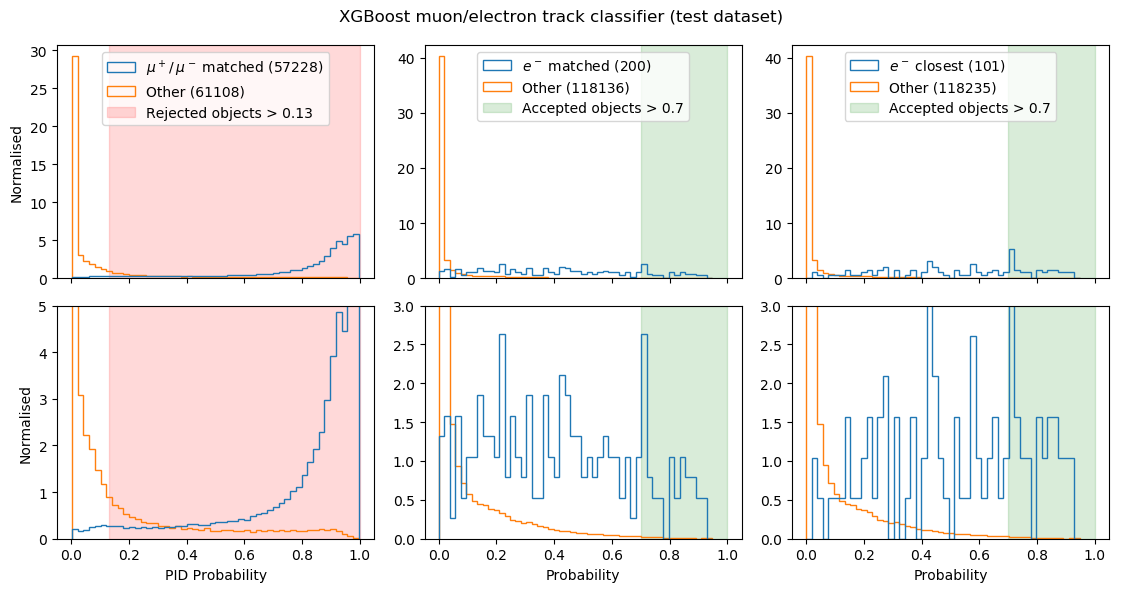

In [10]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r'XGBoost muon/electron track classifier (test dataset)')
N=50
muon_cut = 0.13
electron_cut=0.7
close_e_cut=0.7


# Electron track classification
y_test_e = Y_test['true_e']
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron track classification
y_test_cle = Y_test['track_cle']
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon track classification
y_test_mu = Y_test['true_mu']
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/ \:\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')
label_cl_e=(r'$e^-$ closest ('+str(len(arr_cl_e))+')','Other ('+str(len(arr_cl_ne))+')')

ax[0][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[0][0].set_ylabel('Normalised')


ax[1][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[1][0].set_ylim(0,5)
ax[1][0].set_ylabel('Normalised')
ax[1][0].set_xlabel('PID Probability')

ax[0][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)

ax[1][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
ax[1][1].set_xlabel('Probability')


ax[0][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)

ax[1][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,3)
ax[1][2].set_xlabel('Probability')

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('../Output/XGB_track.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged tracks and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged tracks.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged tracks and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged tracks.')

print('Cut value:',close_e_cut,'keeps', sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),'% of closest electron tagged tracks and',
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),'% of not-closest-electron tagged tracks.')


# Showers

In [11]:
input_sh = ['../Input/intime/intime_shower_9.pckl',
            
            '../Input/nue/nue_shower_0.pckl',
            '../Input/nue/nue_shower_1.pckl',
            '../Input/nue/nue_shower_2.pckl',
            '../Input/nue/nue_shower_3.pckl',
            '../Input/nue/nue_shower_4.pckl',
            
            '../Input/nu/nu_shower_4.pckl',
            '../Input/nu/nu_shower_5.pckl',
            '../Input/nu/nu_shower_6.pckl',
            '../Input/nu/nu_shower_7.pckl',
           ]

input_test = ['../Input/nu/nu_shower_0.pckl',
              '../Input/nu/nu_shower_1.pckl',
              '../Input/nu/nu_shower_2.pckl',
              '../Input/nu/nu_shower_3.pckl',
           ]


#input_sh_data = ['../Input/XGBoost/bnb/showerFrame_data_bnb.pckl',
#                 '../Input/XGBoost/bnbext/showerFrame_data_bnbext.pckl'
#                ]

intput_sh_df = [ pd.read_pickle(x) for x in input_sh]
df_sh_train = pd.concat(intput_sh_df,ignore_index=True,copy=False) 
df_sh_train_lee = pd.read_pickle('../Input/lee_75k/lee_75k_shower_9.pckl')
df_sh_train["bnbweight"]=1
df_sh_train_lee["bnbweight"]=10
df_sh_train= pd.concat([df_sh_train_lee,df_sh_train],ignore_index=True,copy=False) 

intput_sh_df = [ pd.read_pickle(x) for x in input_test]
df_sh_test = pd.concat(intput_sh_df,ignore_index=True,copy=False) 

# Do some things before training on the frame
df_sh_train = pd.get_dummies(df_sh_train,columns=['shower_is_daughter','shower_daughter'],drop_first=True)
df_sh_train["vtx_activity"] = df_sh_train["vtx_activity"].astype("bool")
df_sh_train["true_mu"] = df_sh_train["matched_showers"].abs() == 13
df_sh_train["true_e"] = df_sh_train["matched_showers"] == 11


# Do some things before training on the frame
df_sh_test = pd.get_dummies(df_sh_test,columns=['shower_is_daughter','shower_daughter'],drop_first=True)
df_sh_test["vtx_activity"] = df_sh_test["vtx_activity"].astype("bool")
df_sh_test["true_mu"] = df_sh_test["matched_showers"].abs() == 13
df_sh_test["true_e"] = df_sh_test["matched_showers"] == 11

columns_shower_XGB  = ["shower_open_angle","shower_length",'vtx_activity',
                       "shower_pca", "shower_maxangle","shower_vtxdistance",
                       "shower_fidvol_ratio","shower_spacepoint_dqdx_ratio",
                       "shower_dedx_hits_w","shower_dedx_w","shower_dedx_best_w","shower_hitsratio_w",
                       'shower_is_daughter_1',"shower_is_daughter_2", "shower_daughter_1", "shower_daughter_2", #"shower_daughter_3",
                       #"shower_energy_w", ,"shower_hits_w", "shower_theta","shower_energy_product"
                      ]

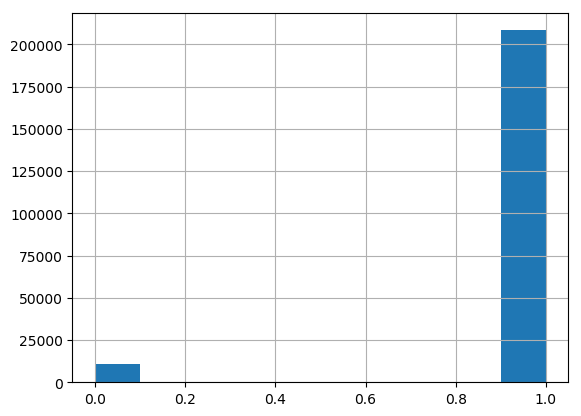

In [12]:
df_sh_train.head()
df_sh_train["vtx_activity"].hist()

In [13]:
# For now, quick fix: require at least x hits in shower_dedx_hits, otherwise shower_dedx is nonsence.
# Also require a reconstructed energy of at leact x Mev
df_sh_train = df_sh_train[df_sh_train['shower_dedx_hits_w']>=min_dedx_hits]
df_sh_test = df_sh_test[df_sh_test['shower_dedx_hits_w']>=min_dedx_hits]
df_sh_train = df_sh_train[df_sh_train['shower_energy_w']>=min_reco_e]
df_sh_test = df_sh_test[df_sh_test['shower_energy_w']>=min_reco_e]
sf_sh_train = df_sh_train[~df_sh_train['shower_start_z'].between(z_dead_start,z_dead_end)]
df_sh_test = df_sh_test[~df_sh_test['shower_start_z'].between(z_dead_start,z_dead_end)]

df_sh_train.head()
print(df_sh_train.columns)

Index(['shower_hits_w', 'shower_dedx_best_w', 'shower_dedx_w', 'shower_length',
       'track_bdt_precut', 'shower_cle', 'shower_start_x', 'shower_start_y',
       'shower_start_z', 'shower_open_angle', 'shower_fidvol_ratio',
       'shower_theta', 'shower_energy_product', 'shower_hitsratio_w',
       'matched_showers', 'shower_pca', 'shower_vtxdistance',
       'matched_showers_energy', 'shower_dedx_hits_w', 'shower_maxangle',
       'bnbweight', 'shower_spacepoint_dqdx_ratio', 'n_showers', 'fiducial',
       'true_1eX_signal', 'shower_energy_w', 'shower_dir_z', 'shower_dir_y',
       'shower_dir_x', 'vtx_activity', '__array_index', 'shower_is_daughter_1',
       'shower_is_daughter_2', 'shower_daughter_1', 'shower_daughter_2',
       'shower_daughter_3', 'true_mu', 'true_e'],
      dtype='object')


In [14]:
X_train = df_sh_train[columns_shower_XGB].as_matrix()
X_test  = df_sh_test[columns_shower_XGB].as_matrix()

X_train_weights = df_sh_train["bnbweight"]

Y_train = df_sh_train[['true_mu','true_e','shower_cle']]
Y_test = df_sh_test[['true_mu','true_e','shower_cle']]

In [15]:
# fit model no training data
label = 'true_mu'
model = XGBClassifier()
model.fit(X_train, Y_train[label])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_mu.pkl') 
y_pred_mu = model.predict_proba(X_test)
y_pred_mu_train = model.predict_proba(X_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       0.79      0.98      0.88     36475
       True       0.76      0.23      0.36     12022

avg / total       0.79      0.79      0.75     48497

Feature ranking:
1. feature shower_length(0.172166)
2. feature shower_vtxdistance(0.153515)
3. feature shower_pca(0.109039)
4. feature shower_maxangle(0.098996)
5. feature shower_dedx_best_w(0.078910)
6. feature shower_dedx_w(0.071736)
7. feature shower_hitsratio_w(0.055954)
8. feature shower_open_angle(0.053085)
9. feature shower_is_daughter_2(0.048780)
10. feature shower_fidvol_ratio(0.044476)
11. feature shower_spacepoint_dqdx_ratio(0.043042)
12. feature shower_dedx_hits_w(0.035868)
13. feature shower_daughter_2(0.020086)
14. feature shower_is_daughter_1(0.011478)
15. feature shower_daughter_1(0.002869)
16. feature vtx_activity(0.000000)


In [16]:
# fit model no training data
label = 'true_e'
model = XGBClassifier()

print(X_train.shape)
print(y_pred_mu_train.size)
print( Y_train[label].size)

model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_e.pkl')
y_pred_e = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

(74593, 16)
149186
74593
             precision    recall  f1-score   support

      False       0.99      0.83      0.90     47019
       True       0.12      0.71      0.20      1478

avg / total       0.96      0.83      0.88     48497

Feature ranking:
1. feature shower_vtxdistance(0.170000)
2. feature shower_length(0.168571)
3. feature shower_dedx_w(0.134286)
4. feature shower_pca(0.075714)
5. feature shower_maxangle(0.070000)
6. feature shower_hitsratio_w(0.065714)
7. feature shower_dedx_best_w(0.064286)
8. feature shower_open_angle(0.055714)
9. feature shower_dedx_hits_w(0.041429)
10. feature shower_spacepoint_dqdx_ratio(0.035714)
11. feature shower_is_daughter_1(0.034286)
12. feature shower_fidvol_ratio(0.031429)
13. feature shower_is_daughter_2(0.025714)
14. feature shower_daughter_1(0.018571)
15. feature shower_daughter_2(0.008571)
16. feature vtx_activity(0.000000)


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [17]:
# fit model no training data
label = 'shower_cle'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_cle.pkl') 
y_pred_cle = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

             precision    recall  f1-score   support

          0       1.00      0.93      0.96     47661
          1       0.17      0.80      0.28       836

avg / total       0.98      0.93      0.95     48497

Feature ranking:
1. feature shower_length(0.206677)
2. feature shower_vtxdistance(0.186010)
3. feature shower_dedx_w(0.108108)
4. feature shower_maxangle(0.098569)
5. feature shower_pca(0.066773)
6. feature shower_hitsratio_w(0.058824)
7. feature shower_dedx_best_w(0.054054)
8. feature shower_is_daughter_2(0.039746)
9. feature shower_dedx_hits_w(0.036566)
10. feature shower_is_daughter_1(0.031797)
11. feature shower_open_angle(0.031797)
12. feature shower_fidvol_ratio(0.030207)
13. feature shower_spacepoint_dqdx_ratio(0.022258)
14. feature shower_daughter_1(0.017488)
15. feature vtx_activity(0.011129)
16. feature shower_daughter_2(0.000000)


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cut value: 0.16 removes 75.4 % of muon tagged shower and 28.1 % of not-muon tagged showers.
Cut value: 0.9 keeps 28.1 % of electron tagged shower and 0.9 % of not-electron tagged showers.
Cut value: 0.9 keeps 46.7 % of closest electron tagged shower and 1.0 % of not-closest-electron tagged showers.


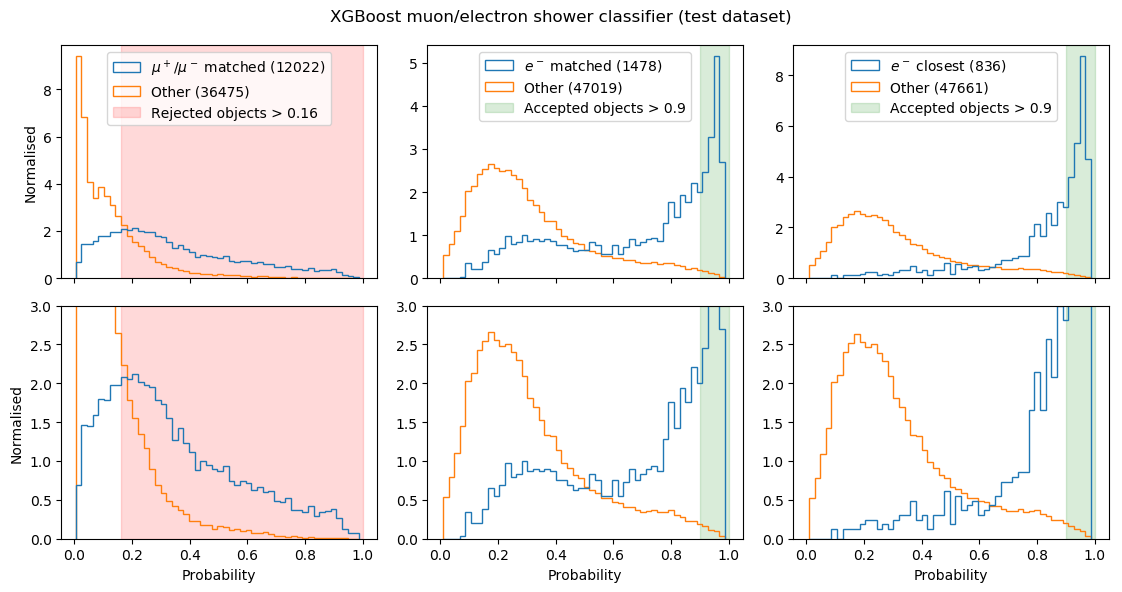

In [18]:
# XGB classification

plt.style.use('default')
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6),sharex=True)
plt.suptitle(r'XGBoost muon/electron shower classifier (test dataset)')
N=50
muon_cut = 0.16
electron_cut=0.90
close_e_cut=0.9

# Electron shower classification
y_test_e = Y_test['true_e']
arr_e  = y_pred_e[y_test_e==1][:,1]
arr_ne = y_pred_e[y_test_e==0][:,1]

# Electron shower classification
y_test_cle = Y_test['shower_cle']
arr_cl_e  = y_pred_e[y_test_cle==1][:,1]
arr_cl_ne = y_pred_e[y_test_cle==0][:,1]

# Muon shower classification
y_test_mu = Y_test['true_mu']
arr_mu  = y_pred_mu[y_test_mu==1][:,1]
arr_nmu = y_pred_mu[y_test_mu==0][:,1]

label_mu=(r'$\mu^+/\mu^-$ matched ('+str(len(arr_mu))+')','Other ('+str(len(arr_nmu))+')')
label_e=(r'$e^-$ matched ('+str(len(arr_e))+')','Other ('+str(len(arr_ne))+')')
label_cl_e=(r'$e^-$ closest ('+str(len(arr_cl_e))+')','Other ('+str(len(arr_cl_ne))+')')


ax[0][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[0][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[0][0].set_ylabel('Normalised')


ax[1][0].axvspan(muon_cut,1, alpha=0.15, color='red',label='Rejected objects > '+str(muon_cut) )
ax[1][0].hist([arr_mu,arr_nmu],histtype='step', bins=N, fill=False,label=label_mu,density=True)
ax[1][0].set_ylim(0,3)
ax[1][0].set_ylabel('Normalised')
ax[1][0].set_xlabel('Probability')

ax[0][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[0][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)

ax[1][1].axvspan(electron_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(electron_cut) )
ax[1][1].hist([arr_e,arr_ne],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1][1].set_ylim(0,3)
ax[1][1].set_xlabel('Probability')


ax[0][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[0][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)

ax[1][2].axvspan(close_e_cut,1, alpha=0.15, color='green',label='Accepted objects > '+str(close_e_cut) )
ax[1][2].hist([arr_cl_e,arr_cl_ne],histtype='step', bins=N, fill=False,label=label_cl_e,density=True)
ax[1][2].set_ylim(0,3)
ax[1][2].set_xlabel('Probability')

#offset=0.05
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc='upper center')
handles, labels = ax[0][2].get_legend_handles_labels()
ax[0][2].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('../Output/XGB_shower.pdf')

print('Cut value:',muon_cut,'removes', sciNot(sum(arr_mu>muon_cut) / len(arr_mu)*100),'% of muon tagged shower and',
      sciNot(sum(arr_nmu>muon_cut) / len(arr_nmu)*100),'% of not-muon tagged showers.')

print('Cut value:',electron_cut,'keeps', sciNot(sum(arr_e>electron_cut) / len(arr_e)*100),'% of electron tagged shower and',
      sciNot(sum(arr_ne>electron_cut) / len(arr_ne)*100),'% of not-electron tagged showers.')

print('Cut value:',close_e_cut,'keeps', sciNot(sum(arr_cl_e>close_e_cut) / len(arr_cl_e)*100),'% of closest electron tagged shower and',
      sciNot(sum(arr_cl_ne>close_e_cut) / len(arr_ne)*100),'% of not-closest-electron tagged showers.')


In [19]:
# fit model no training data
label = 'shower_cle'
model = XGBClassifier()
model.fit(X_train[y_pred_mu_train[:,1]<0.5], Y_train[label][y_pred_mu_train[:,1]<0.5],sample_weight=X_train_weights[y_pred_mu_train[:,1]<0.5])
print(classification_report(Y_test[label],model.predict(X_test)))
joblib.dump(model, '../Input/XGBoost/model_sh_cle_lee.pkl') 
y_pred_cle_lee = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_shower_XGB)):
    print("%d. feature %s(%f)" % (f + 1, columns_shower_XGB[indices[f]],importances[indices[f]]))

             precision    recall  f1-score   support

          0       1.00      0.90      0.95     47661
          1       0.13      0.81      0.22       836

avg / total       0.98      0.90      0.94     48497

Feature ranking:
1. feature shower_vtxdistance(0.187200)
2. feature shower_length(0.164800)
3. feature shower_dedx_w(0.108800)
4. feature shower_maxangle(0.097600)
5. feature shower_pca(0.081600)
6. feature shower_dedx_best_w(0.064000)
7. feature shower_hitsratio_w(0.062400)
8. feature shower_is_daughter_2(0.044800)
9. feature shower_open_angle(0.044800)
10. feature shower_fidvol_ratio(0.036800)
11. feature shower_is_daughter_1(0.030400)
12. feature vtx_activity(0.025600)
13. feature shower_dedx_hits_w(0.022400)
14. feature shower_spacepoint_dqdx_ratio(0.017600)
15. feature shower_daughter_1(0.011200)
16. feature shower_daughter_2(0.000000)


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
